**Anime Recommendation System**

Importing Libraries

In [ ]:
#Importing Libraries

import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Reading csv file

In [ ]:
#Reading anime csv file
anime = pd.read_csv('/content/sample_data/anime.csv')

In [ ]:
#Reading rating csv file
rating = pd.read_csv('/content/sample_data/rating.csv')

Displaying data

In [ ]:
anime.head().style.background_gradient()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.370000,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.260000,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.250000,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.170000,673572
4,9969,Gintama',"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.160000,151266


In [ ]:
rating.head().style.background_gradient()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Information about data

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Describing data

In [ ]:
def above_zero(val):
    color = 'blue' if val > 0 else 'red'
    return 'color: %s' % color
anime.describe().style.applymap(above_zero)

,anime_id,rating,members
count,12294.000000,12064.000000,12294.000000
mean,14058.221653,6.473902,18071.338864
std,11455.294701,1.026746,54820.676925
min,1.000000,1.670000,5.000000
25%,3484.250000,5.880000,225.000000
50%,10260.500000,6.570000,1550.000000
75%,24794.500000,7.180000,9437.000000
max,34527.000000,10.000000,1013917.000000


In [ ]:
def above_zero(val):
    color = 'blue' if val > 0 else 'red'
    return 'color: %s' % color
rating.describe().style.applymap(above_zero)

,user_id,anime_id,rating
count,7813737.000000,7813737.000000,7813737.000000
mean,36727.956745,8909.072104,6.144030
std,20997.946119,8883.949636,3.727800
min,1.000000,1.000000,-1.000000
25%,18974.000000,1240.000000,6.000000
50%,36791.000000,6213.000000,7.000000
75%,54757.000000,14093.000000,9.000000
max,73516.000000,34519.000000,10.000000


In [ ]:
#counting no of ratings
rating.rating.value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

In [ ]:
#-1 means no rating so removing -1 rows
rating = rating[rating["rating"] != -1]

In [ ]:
rating.rating.value_counts()

8     1646019
7     1375287
9     1254096
10     955715
6      637775
5      282806
4      104291
3       41453
2       23150
1       16649
Name: rating, dtype: int64

In [ ]:
#shaping the data
print(f"anime.csv - rows: {anime.shape[0]}, columns: {anime.shape[1]}")
print(f"rating.csv - rows: {rating.shape[0]}, columns: {rating.shape[1]}")

anime.csv - rows: 12294, columns: 7
rating.csv - rows: 6337241, columns: 3


Finding missing values

In [ ]:
isnull=print(anime.isnull())

       anime_id   name  genre   type  episodes  rating  members
0         False  False  False  False     False   False    False
1         False  False  False  False     False   False    False
2         False  False  False  False     False   False    False
3         False  False  False  False     False   False    False
4         False  False  False  False     False   False    False
...         ...    ...    ...    ...       ...     ...      ...
12289     False  False  False  False     False   False    False
12290     False  False  False  False     False   False    False
12291     False  False  False  False     False   False    False
12292     False  False  False  False     False   False    False
12293     False  False  False  False     False   False    False

[12294 rows x 7 columns]


In [ ]:
print(rating.isnull())

         user_id  anime_id  rating
47         False     False   False
81         False     False   False
83         False     False   False
101        False     False   False
153        False     False   False
...          ...       ...     ...
7813732    False     False   False
7813733    False     False   False
7813734    False     False   False
7813735    False     False   False
7813736    False     False   False

[6337241 rows x 3 columns]


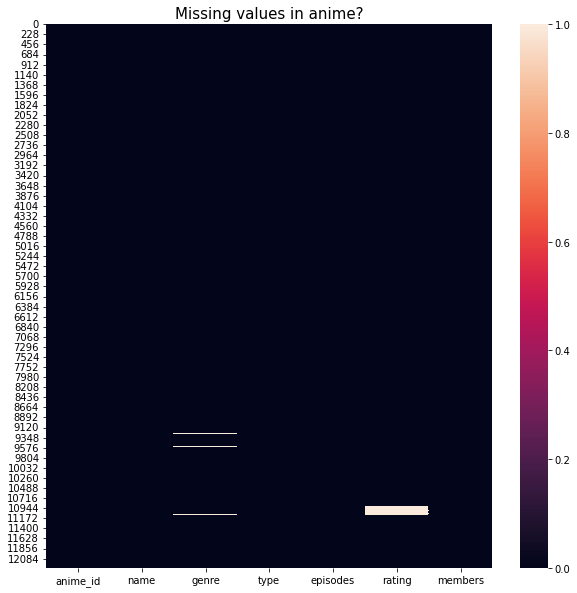

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(anime.isnull())
plt.title("Missing values in anime?", fontsize = 15)
plt.show()

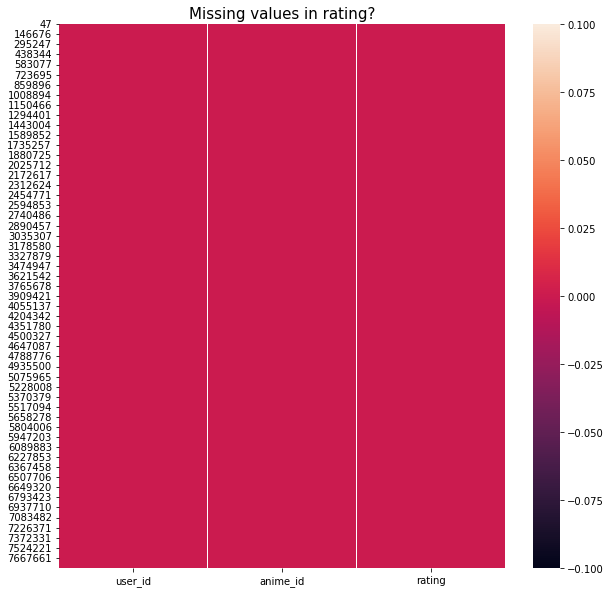

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(rating.isnull())
plt.title("Missing values in rating?", fontsize = 15)
plt.show()

Prepare data

In [ ]:
# Merging anime and rating using "anime_id" as reference
# Only the columns we will use
df = pd.merge(rating,anime[["anime_id","name"]], left_on = "anime_id", right_on = "anime_id").drop("anime_id", axis = 1)
df.rename(columns = {'rating_user':'user_rating'}, inplace = True)
df.head().style.background_gradient()

,user_id,rating,name
0,1,10,Highschool of the Dead
1,3,6,Highschool of the Dead
2,5,2,Highschool of the Dead
3,12,6,Highschool of the Dead
4,14,6,Highschool of the Dead


Counting the rating for each anime

In [ ]:
# Counting the number of ratings for each anime
count_rating = df.groupby("name")["rating"].count().sort_values(ascending = False)
count_rating

name
Death Note                         34226
Sword Art Online                   26310
Shingeki no Kyojin                 25290
Code Geass: Hangyaku no Lelouch    24126
Angel Beats!                       23565
                                   ...  
La Primavera                           1
Chou Zenmairobo: Patrasche             1
Ushi Atama                             1
Gun-dou Musashi Recap                  1
Futago no Ookami Daibouken             1
Name: rating, Length: 9926, dtype: int64

In [ ]:
# Some animes have only 1 rating, therefore it is better for the recommender system to ignore them
# keeping only the animes with at least r ratings
r = 5000
more_than_r_ratings = count_rating[count_rating.apply(lambda x: x >= r)].index

# Keep only the animes with at least r ratings in the DataFrame
df_r = df[df['name'].apply(lambda x: x in more_than_r_ratings)]
print(df_r)

         user_id  rating                    name
0              1      10  Highschool of the Dead
1              3       6  Highschool of the Dead
2              5       2  Highschool of the Dead
3             12       6  Highschool of the Dead
4             14       6  Highschool of the Dead
...          ...     ...                     ...
4999396    73458       7                Shuffle!
4999397    73460       6                Shuffle!
4999398    73499       7                Shuffle!
4999399    73501      10                Shuffle!
4999400    73502       1                Shuffle!

[2517097 rows x 3 columns]


Filtering the data

In [ ]:
before = len(df.name.unique())
after = len(df_r.name.unique())
rows_before = df.shape[0]
rows_after = df_r.shape[0]
print(f'''There are {before} animes in the dataset before filtering and {after} animes after the filtering.

{before} animes => {after} animes
{rows_before} rows before filtering => {rows_after} rows after filtering''')

There are 9926 animes in the dataset before filtering and 279 animes after the filtering.

9926 animes => 279 animes
6337239 rows before filtering => 2517097 rows after filtering


**Collabrative Recommendation system**

In [ ]:
df=df[['user_id', 'name', 'rating']]
df_sub= df[df.user_id <= 5000]
df_sub.head()

NameError: ignored

In [ ]:
# Creating a matrix with userId as rows and the titles of the movies as column.
# Each cell will have the rating given by the user to the animes.
# There will be a lot of NaN values, because each user hasn't watched most of the animes
df_recom = df_r.pivot_table(index='user_id',columns='name',values='rating')
df_recom.iloc[:5,:5]

name,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!
user_id,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,7.0,6.0,NaN,NaN,8.0
5,3.0,NaN,NaN,NaN,4.0
7,8.0,NaN,NaN,NaN,NaN


In [ ]:
print(df_recom.shape)
df_recom.head()

(67921, 279)


name,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!,Akira,Aldnoah.Zero,Amagi Brilliant Park,Angel Beats!,Angel Beats!: Another Epilogue,...,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku,"Yosuga no Sora: In Solitude, Where We Are Least Alone.",Yuu☆Yuu☆Hakusho,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetsuen no Tempest
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,6.0,NaN,NaN,8.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
5,3.0,NaN,NaN,NaN,4.0,8.0,NaN,6.0,3.0,NaN,...,3.0,4.0,NaN,7.0,NaN,1.0,1.0,1.0,1.0,NaN
7,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Note: As we are subtracting the mean from each rating to standardize
# all users with only one rating or who had rated everything the same will be dropped

# Normalize the values
df_recom_norm = df_recom.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)


# Drop all columns containing only zeros representing users who did not rate
df_recom_norm.fillna(0, inplace=True)
df_recom_norm = df_recom_norm.T
df_recom_norm = df_recom_norm.loc[:, (df_recom_norm != 0).any(axis=0)]

In [ ]:
df_recom_sparse = sp.sparse.csr_matrix(df_recom_norm.values)

Cosine similarity matrix 

In [ ]:
item_similarity = cosine_similarity(df_recom_sparse)
user_similarity = cosine_similarity(df_recom_sparse.T)

In [ ]:
item_sim_df = pd.DataFrame(item_similarity, index = df_recom_norm.index, columns = df_recom_norm.index)
user_sim_df = pd.DataFrame(user_similarity, index = df_recom_norm.columns, columns = df_recom_norm.columns)

In [ ]:
df_r.name.value_counts().head(20)

In [ ]:
def top_animes(anime_name):
    count = 1
    print('Similar shows to {} include:\n'.format(anime_name))
    for item in item_sim_df.sort_values(by = anime_name, ascending = False).index[1:11]:
        print('No. {}: {}'.format(count, item))
        count +=1  

In [ ]:
# This function will return the top 5 users with the highest similarity value 

def top_users(user):
    
    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))
    
    print('Most Similar Users:\n')
    sim_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:11]
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    zipped = zip(sim_users, sim_values,)
    for user, sim in zipped:
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim)) 

In [ ]:
# This function constructs a list of lists containing the highest rated shows per similar user
# and returns the name of the show along with the frequency it appears in the list

def similar_user_recs(user):
    
    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))
    
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    best = []
    most_common = {}
    
    for i in sim_users:
        max_score = piv_norm.loc[:, i].max()
        best.append(piv_norm[piv_norm.loc[:, i]==max_score].index.tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5] 

Content-based Filtering

In [ ]:
def find_corr(df, name):
    '''
    Get the correlation of one anime with the others
    
    Args
        df (DataFrame):  with user_id as rows and movie titles as column and ratings as values
        name (str): Name of the anime
    
    Return
        DataFrame with the correlation of the anime with all others
    '''
    
    similar_to_movie = df.corrwith(df[name])
    similar_to_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    similar_to_movie = similar_to_movie.sort_values(by = 'Correlation', ascending = False)
    return similar_to_movie

**Recommendation**

In [ ]:
anime = input(str("Enter anime name: "))

# Recommendations
find_corr(df_recom, anime).head(40)

In [ ]:
# Not recommended
find_corr(df_recom, anime).tail(40)